# Github Actions

Acts as a client to the Github API, and pulls information gathering user actions over time. Data can then be upload to a database for analysis. This extraction is tightly coupled to an Apache Superset dashboard the allows for visualizing key repository metrics.

For reference, see this related nice [Github entity relationship diagram (ERD)](https://docs.google.com/presentation/d/e/2PACX-1vRDd0-PUMa7Jg4O5mNcaDwW3FndDOQZG7ZximXWRgxpyeCnUHSJl2-ZF9HWfktvghLUV8WYp7B8VNXL/embed?start=false&amp;loop=false&amp;delayms=3000&slide=id.g244d368397_0_1) provided on Fivetran's website.


### TODO
* Includes logic to do differential updates

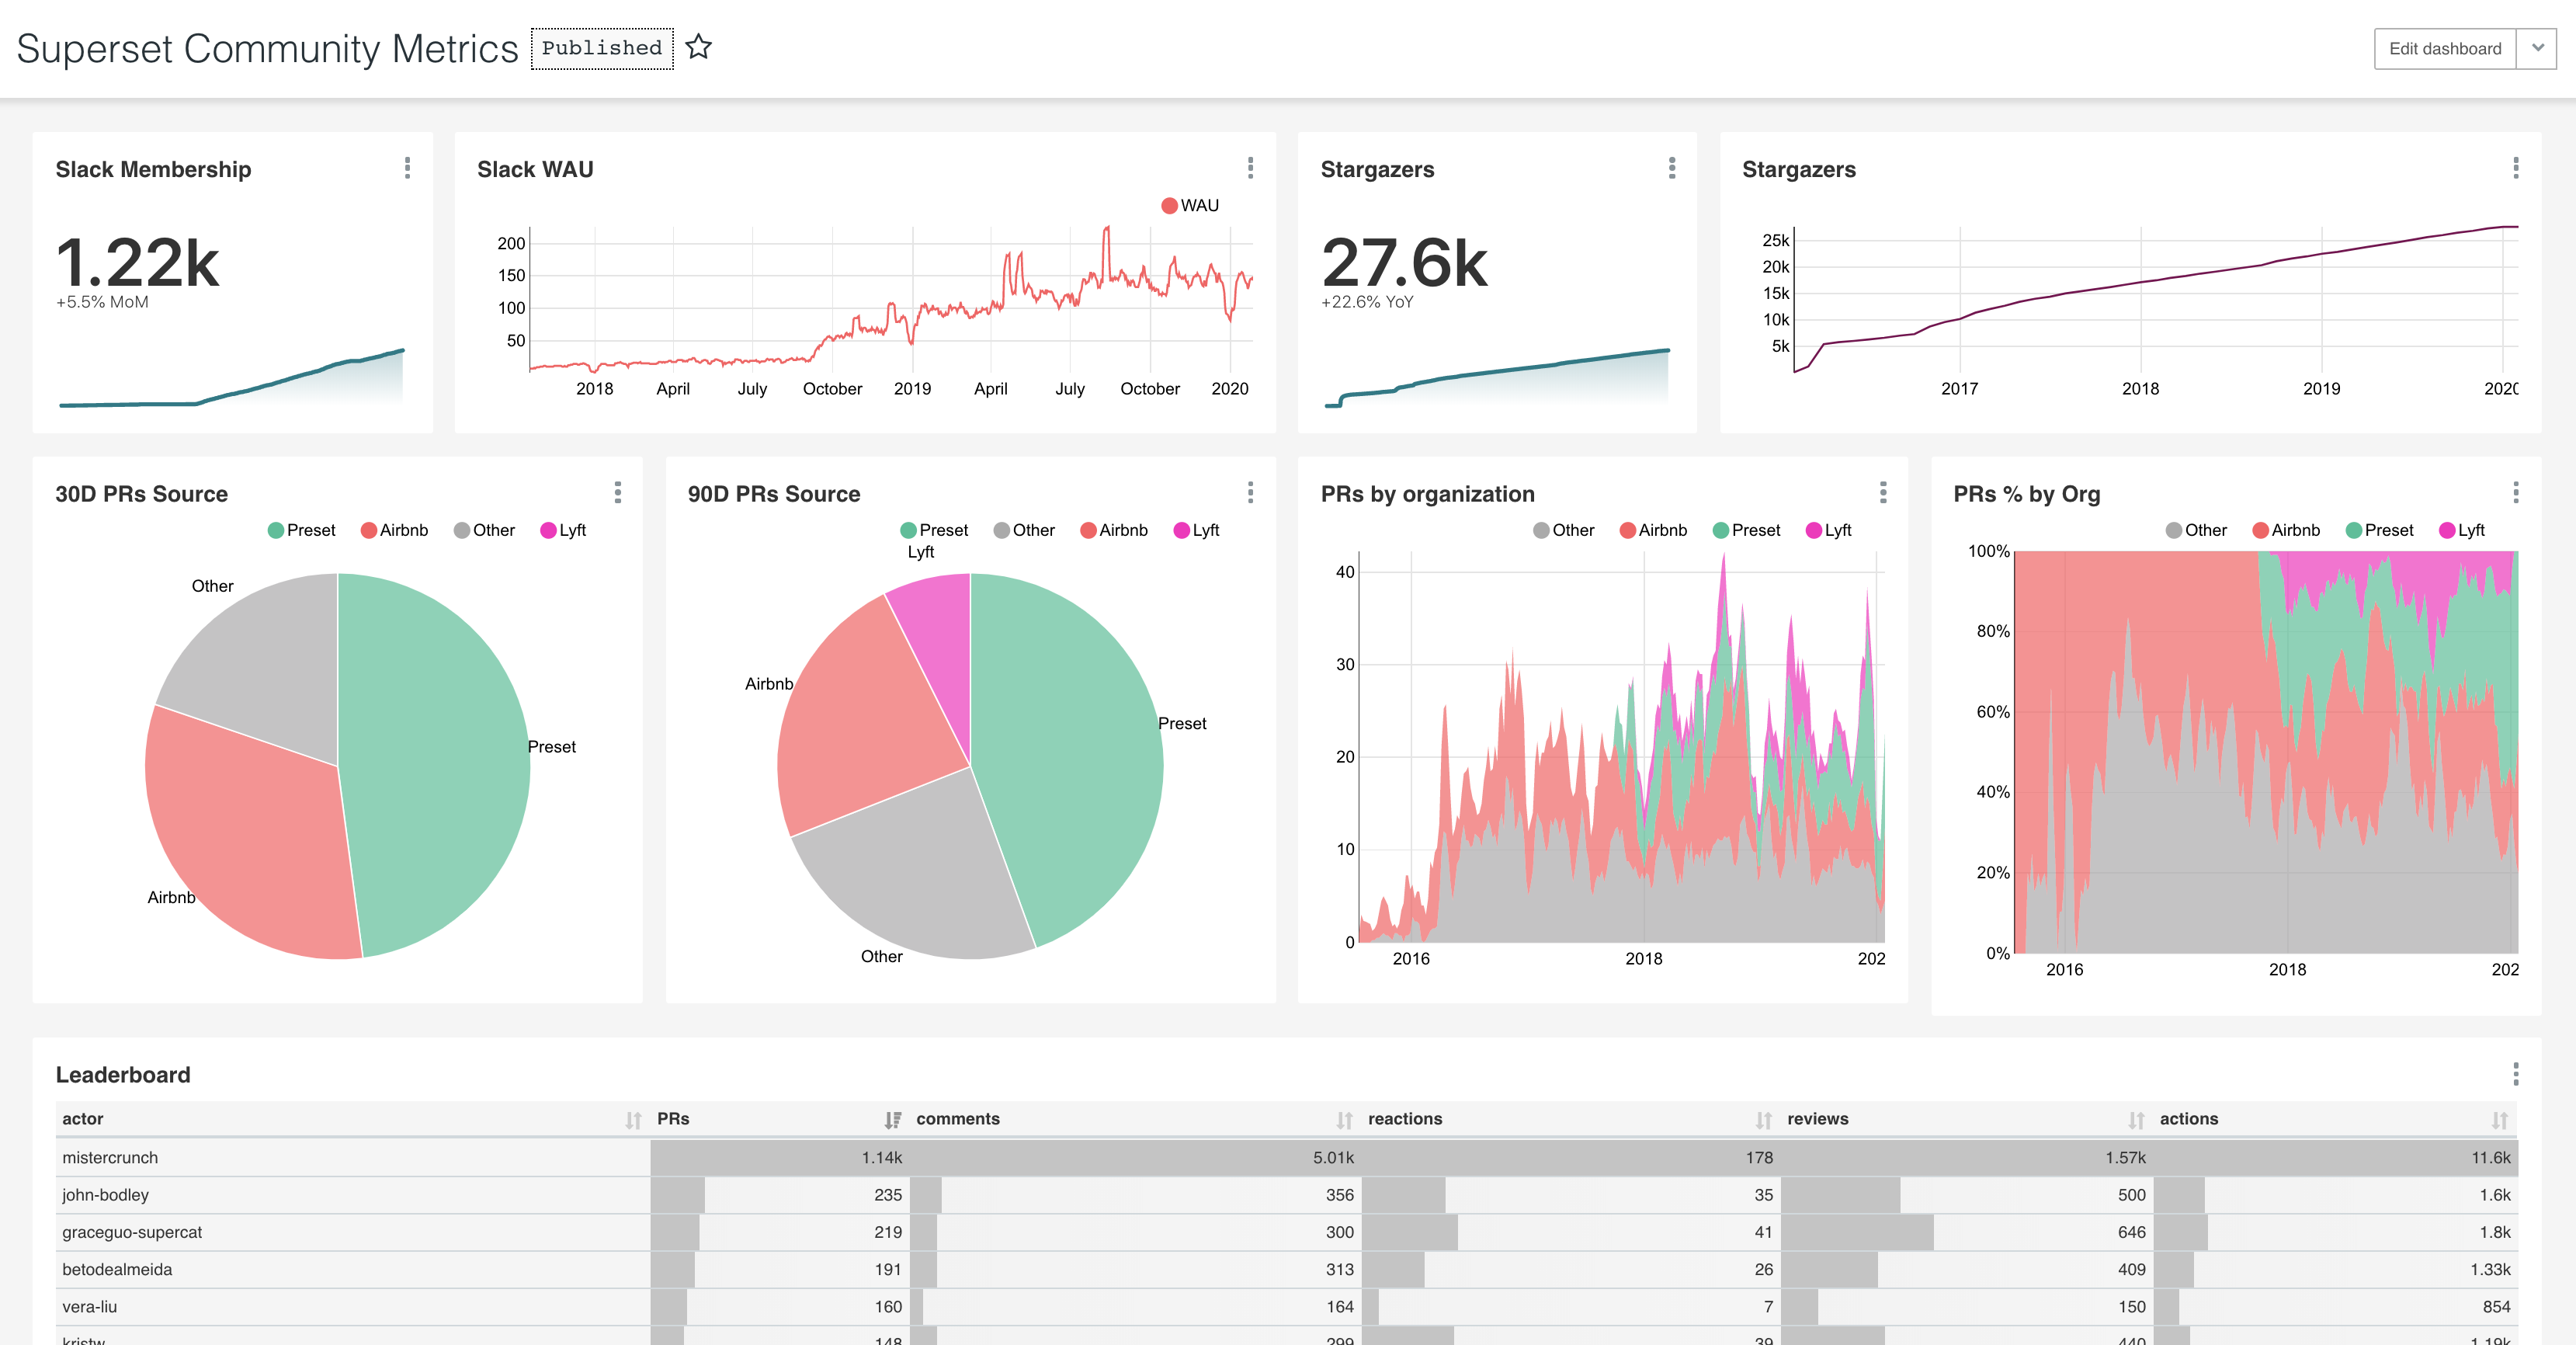

In [1]:
from IPython.display import Image
Image(filename='dash.png') 

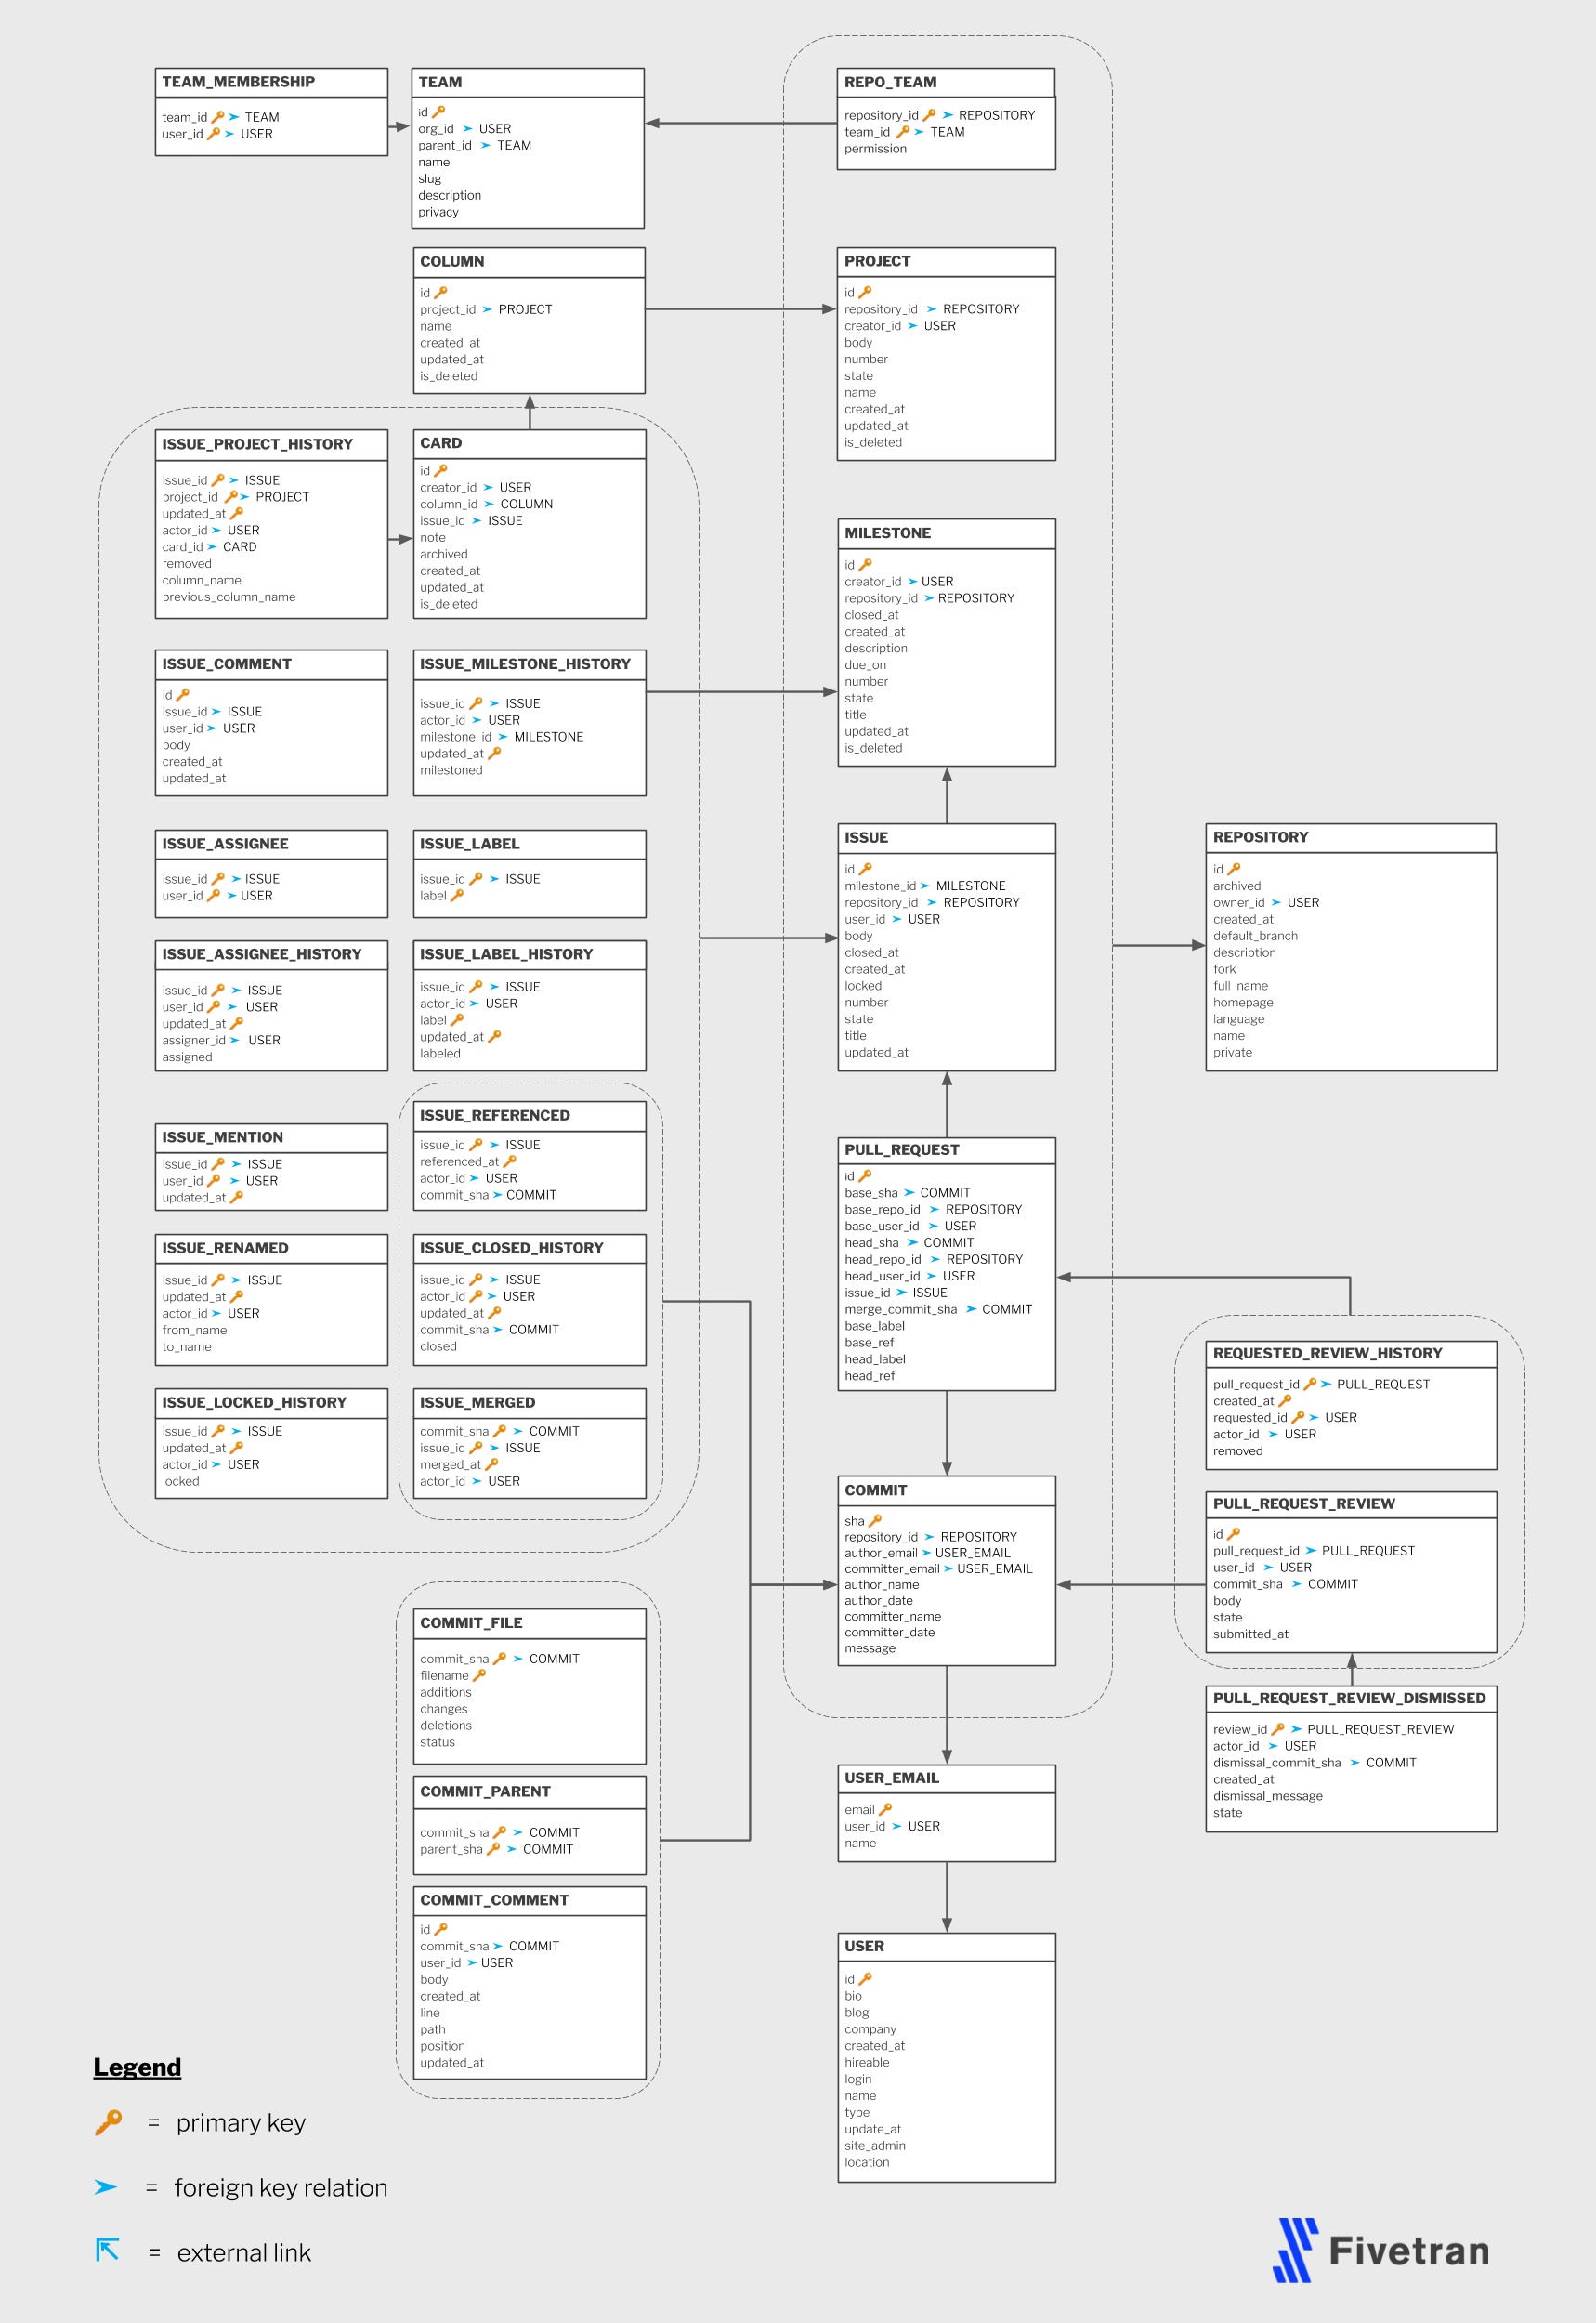

In [4]:
# Thanks to Fivetran for this great ERD of the Github API
Image(filename='github_erd.png') 

In [5]:
from datetime import datetime
import logging
import os
import pickle
import time

from github import Github
from github.Label import Label
from github.GithubException import RateLimitExceededException

import pandas as pd
import sqlalchemy as sqla

In [6]:
cache = {}

In [10]:
REPO = "apache/incubator-superset"
GITHUB_TOKENS = None  # str or list[str], also will try to use an env var GITHUB_TOKEN
RATE_LIMIT_SLEEP = 15
ITEMS_LIMIT = 100000
LOG_AT_EVERY = 25
RATE_LIMIT_BUFFER = 500  # pause when less than that is left
RATE_LIMIT_CHECK_INTERVAL = 50
DB_URI = 'mysql://root@localhost/examples'
BOT_LIST = {
    'codecov-io',
    'stale[bot]',
    'issue-label-bot[bot]',
}

# Cutom logic related to Superset org-assignement 
ORG_MAP = {
    'Airbnb': [
        'john-bodley',
        'graceguo-supercat',
        'kristw', 'vera-liu',
        'michellethomas',
        'timifasubaa',
        'williaster',
        'etr2460',
    ],
    'Preset': [
        'mistercrunch',
        'villebro', 'dpgaspar', 'willbarrett',
        'rusackas', 'craig-rueda', 'nytai',
        'robdiciuccio',
    ],
    'Lyft': ['betodealmeida', 'hughhhh', 'khtruong'],
}
# Reversing the lookup
ORG_LKP = {}
for org, users in ORG_MAP.items():
    for u in users:
        ORG_LKP[u] = org
        
def ATTRIBUTE_ORG_LAMBDA(actor, dttm):
    """Used to define custom organization attribution logic"""
    if actor == 'mistercrunch' and dttm:
        if dttm <= datetime(2017, 10, 1):
            return 'Airbnb'
        elif dttm <= datetime(2018, 12, 1):
            return 'Lyft'
    return ORG_LKP.get(actor, 'Other')


In [84]:
class GithubActionClient:
    version = 0.1  # bumping the version invalidates entries in the cache
    def __init__(self, repo, cache=None, api_tokens=None, attribute_org_func=None):
        """
        A client that connects to the Github API and gets all user actions
        
        At a high level, the client receives a cache object that can be managed externally to
        be longer-lived than the client object, and accumulates actions as it scans the
        different types of objects (issues, stars, watchers, ...).
        
        The `process_all` method is probably the only one you'll need to call, look at its
        docstring for more details as to how to make the client work for you. It can
        be parameterized to run in backfill or incremental mode.
        
        Note that it's fairly common to hit the rate limit (currently at 5k/hour) and that
        the lib supports receiving a list of tokens and will take advantage of that. It's
        fairly relentless and usually tends to restart until it makes it through.
        
        :param repo: a string representing the Github repository (ie: apache/incubator-superset)
        :type repo: str
        :param cache: (optional) a dict to use as a cache, this enables making the cache
          global to the notebook and passed back as the client is re-initialized
        :type cache: dict
        :param api_tokens: (optional) one or many Github API token key, if not specified, we'll
          look and a `GITHUB_TOKEN` envrironment variable 
        :type api_tokens: str or list[str]
        :param attribute_org_func: a function or lambda that receives the actor and datetime
          of the event and returns an org
        :type attribute_org_func:
        """
        self.cache = {} if cache is None else cache
        self.repo = repo
        self.handle_api_tokens(api_tokens)
        self._attribute_org_func = attribute_org_func
        
        # stats
        self.skipped = 0
        self.errors = 0
        self.processed = 0
        self.last_updated_at = None
        self.last_id_processed = None
        
    def reset_cache(self):
        self.cache = {}
        
    def handle_api_tokens(self, api_tokens):
        self._api_token_index = 0
        if api_tokens:
            self.api_tokens = api_tokens
        else:
            # the token currently in use
            envvar_content = os.environ.get("GITHUB_TOKENS") or os.environ.get("GITHUB_TOKEN")
            self.api_tokens = envvar_content.split(',')
        
    @property
    def _current_token(self):
        return self.api_tokens[self._api_token_index]
    
    def _get_github_instance(self):
        return Github(self._current_token, per_page=100)

    def get_repo(self):
        g = self._get_github_instance()
        return g.get_repo(self.repo)
    
    def dump_cache(self, filename=None):
        dt = datetime.now().isoformat().replace('-','_').replace(':', '_')
        filename = filename or f'./cachedump_{dt}.pickle'
        with open(filename, 'wb') as f: 
            pickle.dump(self.cache, f)
    
    def load_cache(self, filename):
        with open(filename, 'rb') as f: 
            self.cache = pickle.load(f)

    def _log_progress(self, i):
        if i and i % LOG_AT_EVERY == 0:
            cache_keys = [s for _, s, _ in self.cache.keys()]
            print(
                f"{datetime.now().isoformat()[10:16]} | "
                f"{i} | "
                f"PRs:{cache_keys.count('pr')} | "
                f"issues:{cache_keys.count('issue')} | "
                f"stars:{cache_keys.count('star')} | "
                f"skipped: {self.skipped} | "
                f"processed: {self.processed} | "
                f"errors: {self.errors} | "
                #f"last_id: {self.last_id_processed} | "
                #f"last_updated: {self.last_updated_at} | "
            )

    def _process_collection(self, key_lambda, get_colection_func, object_processor, overwrite_cache=False):
        """A generic function to process a collection of things
        
        It works in a similar manner whether the collection is stars, issues, watches or else, handles
        logging, errors and rate limit issues consistantly."""
        l = []

        for i, obj in enumerate(get_colection_func()):
            l.append(obj)
            if i > ITEMS_LIMIT:
                break
            self._log_progress(i)
            if i % RATE_LIMIT_CHECK_INTERVAL == 0:
                self.check_rate_limit()
            k = key_lambda(obj)
            if (
                overwrite_cache or
                k not in self.cache or
                (k in self.cache and self.cache[k][0].get('version') != self.version)
            ):
                try:
                    result = object_processor(obj)
                    self.cache[k] = result
                    self.processed += 1
                except Exception as e:
                    self.errors +=1
                    logging.exception(e)
            else:
                self.skipped += 1
            if hasattr(obj, 'updated_at'):
                self.last_updated_at = obj.updated_at
            if hasattr(obj, 'id'):
                self.last_id_processed = obj.id
        return l

    def process_issues(self, overwrite_cache=False, since=None):
        repo = self.get_repo()
        if since:
            get_issues_func = lambda: repo.get_issues(state='all', since=since, direction='asc')
        else:
            get_issues_func = lambda: repo.get_issues(state='all', direction='asc')
        self._process_collection(lambda x: (self.repo, 'pr' if x.pull_request else 'issue', x.number), get_issues_func, self._process_issue, overwrite_cache)

    def _process_star(self, star):
        login = star.user.login
        o = self._create_action('star', star.starred_at, login, login)
        return [o]

    def process_stars(self, overwrite_cache=False, since=None):
        repo = self.get_repo()
        return self._process_collection(lambda x: (self.repo, 'star', x.user.login), lambda: repo.get_stargazers_with_dates(), self._process_star, overwrite_cache)

    def _process_fork(self, fork):
        login = fork.owner.login if fork.owner else None
        o = self._create_action('fork', fork.created_at, login, login)
        return [o]
    
    def process_forks(self, overwrite_cache=False, since=None):
        repo = self.get_repo()
        self._process_collection(lambda x: (self.repo, 'fork', x.owner.login if x.owner else None), lambda: repo.get_forks(), self._process_fork, overwrite_cache)

    def _process_watcher(self, watcher):
        login = watcher.login
        o = self._create_action('watch', watcher.created_at, login, login)
        return [o]
    
    def process_watchers(self, overwrite_cache=False, since=None):
        repo = self.get_repo()
        self._process_collection(lambda x: (self.repo, 'watch', x.login), lambda: repo.get_watchers(), self._process_watcher, overwrite_cache)

    def _process_reaction(self, reaction, labels, title=None):
        return self._create_action('reaction_created', reaction.created_at, reaction.user.login, reaction.id, labels, type_=reaction.content, title=title)

    def _process_comment(self, comment, labels, title):
        actions = []
        actions.append(self._create_action('comment_created', comment.created_at, comment.user.login, comment.id, labels, title=title))
        for reaction in comment.get_reactions():
            actions.append(self._process_reaction(reaction, labels, title))
        return actions

    def _process_issue(self, issue):
        """Process an issues, whether it's a PR or an actual issue"""
        actions = []
        labels = '|'.join([lbl.name for lbl in issue.get_labels()])
        labels = f'|{labels}|'
        title = issue.title
        for reaction in issue.get_reactions():
            actions.append(self._process_reaction(reaction, labels))
            
        closed_at = issue.closed_at
        closed_by = issue.closed_by.login if issue.closed_by else None

        if issue.pull_request:
            # If the issue is a pull request
            pull = issue.as_pull_request()
            o = self._create_action('pr_created', pull.created_at, pull.user.login, pull.number, labels, title=title, closed_at=closed_at, closed_by=closed_by)
            actions.append(o)

            if pull.merged_at:
                duration = (pull.merged_at - pull.created_at).total_seconds()
                actions.append(self._create_action('pr_merged', pull.merged_at, pull.merged_by.login, pull.number, labels, duration=duration, title=title, closed_at=closed_at, closed_by=closed_by))
            if pull.closed_at:
                duration = (pull.closed_at - pull.created_at).total_seconds()
                actions.append(self._create_action('pr_closed', pull.closed_at, pull.user.login, pull.number, labels, duration=duration, title=title, closed_at=closed_at, closed_by=closed_by))

            for review in pull.get_reviews():
                login = review.user.login if review.user else None
                try:
                    dttm = review.submitted_at
                except Exception as e:
                    # TODO research corner case on a single PR / review
                    continue
                id_ = review.id
                actions.append(self._create_action('pr_review', dttm, login, id_, labels, title=title, closed_at=closed_at, closed_by=closed_by))
        else:
            actions.append(self._create_action('issue_created', issue.created_at, issue.user.login, issue.number, labels, title=title))
            if issue.closed_at:
                duration = (issue.closed_at - issue.created_at).total_seconds()
                actions.append(self._create_action('issue_closed', issue.closed_at, issue.user.login, issue.number, labels, duration=duration, title=title))
            
        for comment in issue.get_comments():
            actions += self._process_comment(comment, labels, title)
        for reaction in issue.get_reactions():
            actions.append(self._process_reaction(reaction, labels, title=title))
        return actions

    def _create_action(self, action, dttm, actor, id_=None, labels=None, type_=None, duration=None, title=None, closed_at=None, closed_by=None):
        return {
            'action': action,
            'dttm': dttm,
            'actor': actor,
            'labels': labels,
            'id': id_,
            'type': type_,
            'duration': duration,
            'org': self._attribute_org_func(actor, dttm) if self._attribute_org_func else None,
            'title': title,
            'closed_at': closed_at,
            'closed_by': closed_by,
            'is_bot': actor in BOT_LIST,
            'version': self.version,
        }

    def get_rate_limit(self):
        gh = self._get_github_instance()
        rl = gh.get_rate_limit()
        return rl.core
    
    def _switch_token(self):
        if len(self.api_tokens) > 1:
            self._api_token_index += 1
            if self._api_token_index >= len(self.api_tokens):
                self._api_token_index = 0
            print(f"Switching to using token #{self._api_token_index}")
            return True
        return False

    def check_rate_limit(self, sleep=True):
        rate_limit = self.get_rate_limit()
        while rate_limit.remaining < RATE_LIMIT_BUFFER:
            print(f"[rate limit] {rate_limit.remaining} remaining, buffer is {RATE_LIMIT_BUFFER}, reset: {rate_limit.reset}")
            if sleep:
                print(f"Sleeping for {RATE_LIMIT_SLEEP} seconds ...")
                time.sleep(RATE_LIMIT_SLEEP)
            self._switch_token()
            rate_limit = self.get_rate_limit()

    def process_all(self, overwrite_cache=False, since=None, issues=True, stars=True, forks=True, watchers=True):
        """Process everything!
        
        Two main operation mode here: incremental (using the `since` parameter, usually in combination with
        the overwrite_cache=True) or more of a backfill/first load approach where you typically just
        call `process_all()`. On large repository, this is likely to take a long time (hours), and it's
        been known to fail half way (closing your laptop, network disconnect, ...). Restarting the process
        should leverage the cache and go much faster to get to where it left off.
        """
        # Check if we're good to go
        self.check_rate_limit(sleep=False)
        done = False
        while not done:
            try:
                if issues:
                    print("Processing issues")
                    self.process_issues(overwrite_cache, since)
                if stars:
                    print("Processing stars")
                    self.process_stars(overwrite_cache, since)
                if forks:
                    print("Processing forks")
                    self.process_forks(overwrite_cache, since)
                if watchers:
                    print("Processing watchers")
                    self.process_watchers(overwrite_cache, since)
                done = True
            except RateLimitExceededException as e:
                print(f"Hit rate limit... remaining: {self.get_rate_limit()}")
                self.check_rate_limit()
            #except Exception as e:
            #    logging.error("Uh oh...")
            #    pass
        
    def get_df_from_cache(self):
        """Returns a pandas dataframe from the cache"""
        rows = []
        for (repo, object_type, id_), action_list in self.cache.items():
            for action in action_list:
                action.update({
                    'repo': repo,
                    'parent_type': object_type,
                    'parent_id': id_,
                })
                rows.append(action)
        df = pd.DataFrame(rows)
        return df
    
    def to_sql(self, incremental=False, **kwargs):
        """Flushes to database, takes all arguments that Pandas' to_sql takes"""
        df = self.get_df_from_cache()
        conn = sqla.create_engine(DB_URI)
        table_name = 'tmp_github_actions' if incremental else 'github_actions'
        dtype = dict(
            index=sqla.types.BIGINT,
            action=sqla.types.VARCHAR(50),
            actor=sqla.types.VARCHAR(250),
            labels=sqla.types.TEXT,
            id=sqla.types.VARCHAR(50),
            type=sqla.types.VARCHAR(50),
            duration=sqla.types.INT,
            org=sqla.types.VARCHAR(500),
            title=sqla.types.TEXT,
            repo=sqla.types.VARCHAR(500),
            parent_type=sqla.types.VARCHAR(500),
            parent_id=sqla.types.VARCHAR(500),
        )
        df.to_sql(table_name, conn, if_exists='replace', dtype=dtype, **kwargs)
        

In [ ]:
# Run the process for a list of repos
SINCE = datetime(2020, 2, 1)
repos = [
    'apache-superset/superset-ui',
    'apache-superset/superset-ui-plugins',
    'apache/airflow',
    'apache/incubator-superset',
]
for repo in repos:
    print(f"Processing repo: {repo}")
    ghc = GithubActionClient(repo, cache, GITHUB_TOKENS, ATTRIBUTE_ORG_LAMBDA)
    ghc.process_all()


Processing repo: apache-superset/superset-ui
[rate limit] 0 remaining, buffer is 500, reset: 2020-03-19 15:50:40
Switching to using token #1
2020-03-19T08:35 | 25 | PRs:12110 | issues:4268 | stars:44164 | skipped: 0 | processed: 25 | errors: 0 | last_id: 378078035 | 


In [91]:
# Push to the database
ghc = GithubActionClient(REPO, cache, GITHUB_TOKENS, ATTRIBUTE_ORG_LAMBDA)
ghc.to_sql(incremental=False)

In [384]:
upsert_sql = """
SELECT 
    a.index,
    a.action,
    a.dttm,
    a.actor,
    a.labels,
    a.id,
    a.type,
    a.duration,
    a.org,
    a.title,
    a.repo,
    a.parent_type,
    a.parent_id
FROM github_actions a
LEFT JOIN tmp_github_actions b ON CAST(a.id AS TEXT) = CAST(b.id AS TEXT) AND a.action = b.action
WHERE b.dttm IS NULL
UNION ALL
SELECT
    index,
    action,
    dttm,
    actor,
    labels,
    id,
    type,
    duration,
    org,
    title,
    repo,
    parent_type,
    parent_id
FROM tmp_github_actions
"""